In [ ]:
"""
NAME: make_slit

PURPOSE: Calculates the pixel locations for slits of varying width between start [xi,yi] and stop [xf,yf] pixels.

INPUT: 
[1] Path to a csv file with slit_name,xi,yi,xf,yf,width.
[2] Path to save the slit arrays.

OUTPUT: 
[1] Stores the slit array in a path_to_save/slit_name/slit.npy file.
[2] Stores the slit info in path_to_save/slit_name/info.csv file.

HISTORY: 

[1] Created by Rohan Kumar (IISER Kolkata) on 20-05-2023.
"""


import numpy as np
import pandas as pd
import os

def make_slit(xi,yi,xf,yf,width):
    slit_pix=[]
    length=int(((xi-xf)**2+(yi-yf)**2)**0.5)
    if width!=1:
        slope_slit=(yf-yi)/(xf-xi)
        slope_slit_perp=-1/slope_slit
        theta=np.arctan(slope_slit_perp)
        xi_neg=xi-width/2*np.cos(theta)
        xi_pos=xi+width/2*np.cos(theta)
        yi_neg=yi-width/2*np.sin(theta)
        yi_pos=yi+width/2*np.sin(theta)
        xi=xi_neg+(xi_pos-xi_neg)/(width-1)*np.arange(0,width,1,dtype=int)
        yi=yi_neg+(yi_pos-yi_neg)/(width-1)*np.arange(0,width,1,dtype=int)
        xi=np.asarray(xi,dtype=int)
        yi=np.asarray(yi,dtype=int)
        start_cords=np.column_stack((xi,yi))

        xf_neg=xf-width/2*np.cos(theta)
        xf_pos=xf+width/2*np.cos(theta)
        yf_neg=yf-width/2*np.sin(theta)
        yf_pos=yf+width/2*np.sin(theta)
        xf=xf_neg+(xf_pos-xf_neg)/(width-1)*np.arange(0,width,1,dtype=int)
        yf=yf_neg+(yf_pos-yf_neg)/(width-1)*np.arange(0,width,1,dtype=int)
        xf=np.asarray(xf,dtype=int)
        yf=np.asarray(yf,dtype=int)
        end_cords=np.column_stack((xf,yf))
        for i in range(len(start_cords)):
            slit_coords_x=start_cords[i,0]+(end_cords[i,0]-start_cords[i,0])/(length-1)*np.arange(0,length,1,dtype=int)
            slit_coords_y=start_cords[i,1]+(end_cords[i,1]-start_cords[i,1])/(length-1)*np.arange(0,length,1,dtype=int)
            slit_coords_x=np.asarray(slit_coords_x,dtype=int)
            slit_coords_y=np.asarray(slit_coords_y,dtype=int)
            slit_coords=np.column_stack((slit_coords_x,slit_coords_y))
            slit_pix.append(slit_coords)
    else:
        slit_coords_x=xi+(xf-xi)/(length-1)*np.arange(0,length,1,dtype=int)
        slit_coords_y=yi+(yf-yi)/(length-1)*np.arange(0,length,1,dtype=int)
        slit_coords_x=np.asarray(slit_coords_x,dtype=int)
        slit_coords_y=np.asarray(slit_coords_y,dtype=int)
        slit_coords=np.column_stack((slit_coords_x,slit_coords_y))
        slit_pix.append(slit_coords)
    return(slit_pix)

df=pd.read_csv(input("Enter path of csv file with slit coordinates and names: "),sep=',',header=0,names=["slit name","xi","yi","xf","yf","width"])
path_to_save=input("Enter path to save the slits: ")+"/"

data=df.to_numpy()

for i in range(np.shape(data)[0]):
    slits=make_slit(data[i,1],data[i,2],data[i,3],data[i,4],data[i,5])
    directory=path_to_save+f"{data[i,0]}"+"/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.save(directory+"slits.npy",slits)
    df1=pd.DataFrame({"slit name":[data[i,0]],"xi":[data[i,1]],"yi":[data[i,2]],"xf":[data[i,3]],"yf":[data[i,4]],"width":[data[i,5]],"folder":[directory]})
    df1.to_csv(directory+"info.csv",index=False)

In [13]:

"""
NAME: make_xtmap

PURPOSE: Makes interpolated xt-map of the data according to the provided slits. 

INPUT: 
[1] Path to the folder containing both Data and Slits folder. [A specific format is being followed]

OUTPUT: 
[1] Stores the generated xt_map.csv in the specific slit folder.
[2] Adds the location of the dataset in info.csv

IMPORTANT:
This program requires a very specific folder structure to run.
It takes in parent folder location and picks up data from parent_folder_location/Data/ and picks up slit information from parent_folder_location/Slits/.
It runs for all the slits in the Slits folder. Note that the slits are named S1,S2 and so on in Slits/.

HISTORY: 

[1] Created by Rohan Kumar (IISER Kolkata) on 20-05-2023.
"""


import numpy as np
import glob
import pandas as pd
from scipy.io.idl import readsav
from types import SimpleNamespace
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def apply_slits(slit,data):
    y,x=np.split(slit,2,axis=1)
    x1=x+1
    y1=y+1
    x_1=x-1
    y_1=y-1
    sl_1=np.column_stack((x1,y1))
    sl_2=np.column_stack((x_1,y_1))
    sl_3=np.column_stack((x_1,y1))
    sl_4=np.column_stack((x1,y_1))
    pix0=[]
    pix1=[]
    pix2=[]
    pix3=[]
    pix4=[]
    pix0=data[x,y].T[0]
    pix1=data[x1,y1].T[0]
    pix2=data[x_1,y_1].T[0]
    pix3=data[x_1,y1].T[0]
    pix4=data[x1,y_1].T[0]
    inter_slit_1=interp1d(pix_array,pix0,kind='cubic')
    inter_slit_2=interp1d(pix_array,pix1,kind='cubic')
    inter_slit_3=interp1d(pix_array,pix2,kind='cubic')
    inter_slit_4=interp1d(pix_array,pix3,kind='cubic')
    inter_slit_5=interp1d(pix_array,pix4,kind='cubic')
    return((inter_slit_1(pix_array)+inter_slit_2(pix_array)+inter_slit_3(pix_array)+inter_slit_4(pix_array)+inter_slit_5(pix_array))/5)
    return((pix0+pix1+pix2+pix3+pix4)/5)
    return(pix0)

def make_xt(data,slit):
    yslit, xslit=np.split(slit,2,axis=1)
    sz1 = np.shape(data)
    #length=int(((xslit[0]-xslit[-1])**2+(yslit[0]-yslit[-1])**2)**0.5)
    xslit = np.asarray(xslit,dtype = 'int')
    yslit = np.asarray(yslit,dtype='int')
    # xt = np.zeros((sz1[0],length),dtype=float)
    xt=[]
    for i in np.arange(sz1[0]):
        #data_xt = np.transpose(data[i,:,:])
        data_xt = data[i,:,:]
        xtc = (data_xt[xslit,yslit]+data_xt[xslit+1,yslit+1]+data_xt[xslit+1,yslit-1]+data_xt[xslit-1,yslit+1]+data_xt[xslit-1,yslit-1])/5.0
        # print(xtc[:,0])
        # input("Enter")
        # xt[i,:] = xtc[:,0]
        xt.append(xtc[:,0])
    return(np.array(xt))

folder_uni="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/Test Data"+"/"
slit_folder_uni=folder_uni+"Slits"+"/"
for slit_folder in sorted(glob.glob(slit_folder_uni+"S*")):
    xt_map=[]
    k=0
    n=0
    slits=np.load(slit_folder+"/"+"slits.npy")
    df=pd.read_csv(slit_folder+"/"+"info.csv",sep=',',header=0,names=["slit name","xi","yi","xf","yf","width","folder"])
    info_data=df.to_numpy()
    length=int(((info_data[0,1]-info_data[0,3])**2+(info_data[0,2]-info_data[0,4])**2)**0.5)
    pix_array=np.arange(0,length)

    folder_in=folder_uni+"Data"+"/"+"filter_cube_2796.sav"
    df=readsav(folder_in)
    var=SimpleNamespace(**df)
    file=var.filter_cube
    #print(np.shape(var))
    # print(slits)

    for i in range(np.shape(file)[0]):
        arr=np.zeros((length,))
        k+=1
        #file=fits.open(file)
        data=file[i]
        for slit in slits:
            arr+=apply_slits(slit,data,i) 
            arr=arr/len(slits)
        xt_map.append(arr)

    # xt_map=np.array(xt_map)
    # for slit in slits:
    #     xt_map=make_xt(file,slit)
    %matplotlib
    plt.imshow(np.transpose(xt_map))
    # np.savetxt(folder_uni+"xt_map.csv",np.flip(xt_map,axis=1),delimiter=',')
    # df["dataset"]=folder_in
    # df.to_csv(slit_folder+"/"+"info.csv",index=False)
    plt.show()

/tmp/ipykernel_6433/2487696124.py:27: DeprecationWarning: Please use `readsav` from the `scipy.io` namespace, the `scipy.io.idl` namespace is deprecated.
  from scipy.io.idl import readsav


Using matplotlib backend: TkAgg


In [5]:
plt.show()

In [ ]:
slit_location="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/Test Data/point8.sav"

In [ ]:
from scipy.io.idl import readsav
from types import SimpleNamespace

In [ ]:
df=readsav(slit_location)
var=SimpleNamespace(**df)

In [ ]:
var

In [28]:
xt_map_file="/home/vampy/acads/projects/Probing_high_freq_waves_in_corona/Data/Test Data/xt_map.csv"

df=pd.read_csv(xt_map_file)
xt_map=df.to_numpy()

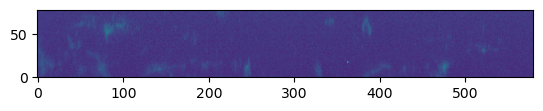

In [29]:
plt.imshow(xt_map,origin='lower',vmin=-5,vmax=5)

In [17]:
data[421,264]

-3.2933452

In [18]:
xt_map

array([[-2.90438581, -3.03321052, -3.20497656, ..., -3.50556755,
        -3.67733359, -3.37674284],
       [-3.33380127, -3.37674284, -3.20497656, ..., -3.8061583 ,
        -3.2908597 , -3.63439202],
       [-3.59145045, -3.11909366, -3.46262598, ..., -3.11909366,
        -3.76321673, -3.63439202],
       ...,
       [-3.31231761, -3.15902233, -3.46561265, ..., -3.00572729,
        -3.31231761, -2.90353036],
       [-3.61890793, -3.36341596, -3.10792398, ..., -3.46561265,
        -2.95462871, -3.10792398],
       [-3.29334521, -3.13852787, -3.49976826, ..., -3.36341596,
        -3.19013357, -3.03531647]])